# Librearies - setup

In [ ]:
!pip install datasets
!pip install transformers
!pip install peft
!pip install faiss-gpu
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 9.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-non

In [ ]:
# Importaciones de bibliotecas estándar
import os
import time
import random
import json
import copy
import re
import glob
from typing import List
from statistics import mean, stdev
from collections import defaultdict

# Importaciones para el manejo de datos
import pandas as pd
import numpy as np
from numpy.linalg import norm, pinv
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    brier_score_loss
)
from sklearn.covariance import EmpiricalCovariance

# Importaciones para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.distributions import Categorical, Beta, kl_divergence, Uniform
import torch.distributions as distributions
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

# Importaciones de transformers y modelos específicos
import transformers
from transformers import (
    RobertaModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
    BertModel,
    BertTokenizer,
    AdamW
)

# Importaciones de otras bibliotecas de aprendizaje automático y análisis de datos
from datasets import load_dataset, ClassLabel, Dataset
from scipy.stats import entropy, weibull_min
from scipy.special import logsumexp
from scipy.stats import beta
from numpy.linalg import norm, pinv

# Importaciones de herramientas adicionales y específicas
import faiss
from tqdm import tqdm

from peft import (
    PeftModel,
    PeftConfig,
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)


# Configuración del dispositivo (GPU/CPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_id = 0
total_memory = torch.cuda.get_device_properties(gpu_id).total_memory
used_memory = torch.cuda.memory_allocated(gpu_id)
reserved_memory = torch.cuda.memory_reserved(gpu_id)

# Impresión de información sobre la memoria de la GPU
print(f"Total memory: {total_memory / 1e9} GB")
print(f"Used memory: {used_memory / 1e9} GB")
print(f"Reserved memory: {reserved_memory / 1e9} GB")

# Para poder correr varios experimentos y replicarlos
def set_seed(seed):
    """ Establece la semilla para reproducibilidad en diferentes módulos. """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    transformers.set_seed(seed)

def prepare_environment(seed, device):
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    set_seed(seed)

    return torch.device(device if torch.cuda.is_available() else "cpu")

Total memory: 15.835660288 GB
Used memory: 0.0 GB
Reserved memory: 0.0 GB


# Data

In [ ]:
""" Collate function personalizada para DataLoader. """
def custom_collate_fn(batch):
    # Transformación de los códigos de generalización
    transform_code = {'far-OOD': -2, 'near-OOD': -1, 'covariate-shift': 0, 'ID': 1}
    generalisation_values = torch.tensor([transform_code[ex["generalisation"]] for ex in batch])

    # Extrae 'input_ids' y 'attention_mask', y aplica padding manualmente si es necesario
    input_ids = pad_sequence([torch.tensor(ex['input_ids']) for ex in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([torch.tensor(ex['attention_mask']) for ex in batch], batch_first=True, padding_value=0)
    labels = torch.tensor([ex['labels'] for ex in batch])

    # Retorna un diccionario con los componentes del batch correctamente alineados y con padding
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'generalisation': generalisation_values
    }

""" Codifica las etiquetas del lote utilizando LabelEncoder. """
def encode_labels(batch, le):
    batch['labels'] = [le.transform([label])[0] if label in le.classes_ else -1 for label in batch['labels']]
    return batch

tokenizer = AutoTokenizer.from_pretrained('roberta-base', padding_side="right")

# key: path_df, value: max_l
dfs_data = {
    '/content/drive/MyDrive/tesis_2024/datasets/v2/setup1_clinc.csv': 30,
    '/content/drive/MyDrive/tesis_2024/datasets/v2/setup2_nc.csv': 50,
    '/content/drive/MyDrive/tesis_2024/datasets/v2/setup3_trec.csv': 40
}

mapping_dataset_name = {
    0: 'Clinc150',
    1: 'NCv3',
    2: 'TREC'
}

experiments = {}

for i, (df_path, max_l) in enumerate(dfs_data.items()):

  df = pd.read_csv(df_path)
  # Elimina datos con solo números, interpretados como float/int
  df = df[df['data'].apply(lambda x: isinstance(x, str))]

  dataset = Dataset.from_pandas(df)
  dataset = dataset.remove_columns('Unnamed: 0')

  # Configuración de codificadores
  label_encoder = LabelEncoder()
  classes_list_without_ood = list(set([row['labels'] for row in dataset if row['generalisation'] not in ['near-OOD', 'far-OOD']]))
  label_encoder.fit(classes_list_without_ood)

  dataset = dataset.map(encode_labels, batched=True, fn_kwargs={'le': label_encoder})
  tokenize_function = lambda df: tokenizer(df['data'], padding='max_length', truncation=True, max_length=max_l)
  tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['data'])

  df = tokenized_dataset.to_pandas()
  if '__index_level_0__' in df.columns:
    df.drop('__index_level_0__', axis=1, inplace=True, errors='ignore')
  train_dataset = Dataset.from_pandas(df[df['group']=='train'])
  train_dataloader = DataLoader(
      train_dataset,
      shuffle=True,
      batch_size=32,
      collate_fn=custom_collate_fn
  )
  eval_dataset = Dataset.from_pandas(df[df['group']=='validation'])
  eval_dataloader = DataLoader(
      eval_dataset,
      shuffle=True,
      batch_size=32,
      collate_fn=custom_collate_fn
  )
  test_dataset = Dataset.from_pandas(df[df['group']=='test'])
  test_dataloader = DataLoader(
      train_dataset,
      shuffle=True,
      batch_size=32,
      collate_fn=custom_collate_fn
  )

  experiments[f'setup {mapping_dataset_name[i]}'] = {
      'train_dataloader': train_dataloader,
      'eval_dataloader': eval_dataloader,
      'test_dataloader': test_dataloader
  }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/24900 [00:00<?, ? examples/s]

Map:   0%|          | 0/24900 [00:00<?, ? examples/s]

Map:   0%|          | 0/226203 [00:00<?, ? examples/s]

Map:   0%|          | 0/226203 [00:00<?, ? examples/s]

Map:   0%|          | 0/6373 [00:00<?, ? examples/s]

Map:   0%|          | 0/6373 [00:00<?, ? examples/s]

/content/drive/MyDrive/tesis_2024/datasets/setup1_clinc.csv


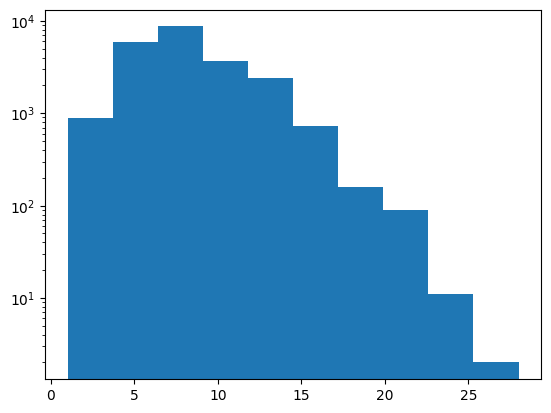

--------------------------------------------------
/content/drive/MyDrive/tesis_2024/datasets/setup2_nc.csv


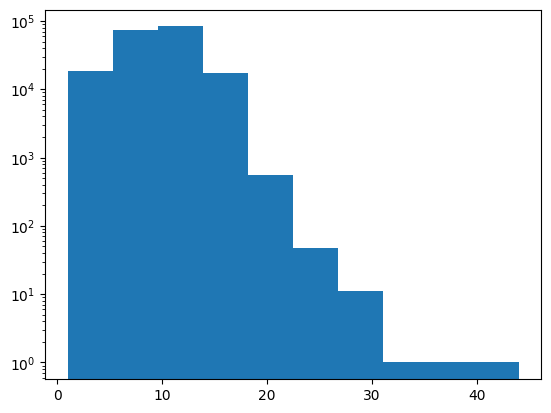

--------------------------------------------------
/content/drive/MyDrive/tesis_2024/datasets/setup3_trec.csv


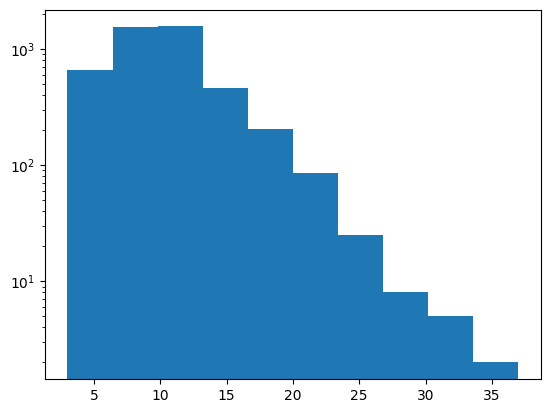

--------------------------------------------------


In [ ]:
# Visualize length ID data
paths = [
    '/content/drive/MyDrive/tesis_2024/datasets/setup1_clinc.csv',
    '/content/drive/MyDrive/tesis_2024/datasets/setup2_nc.csv',
    '/content/drive/MyDrive/tesis_2024/datasets/setup3_trec.csv'
]

for p in paths:
  print(p)
  df = pd.read_csv(p)
  plt.hist(df[df['generalisation']=='ID']['data'].apply(lambda x: len(str(x).split())))
  plt.yscale('log')
  plt.show()
  print('-'*50)

# Functions

In [ ]:
'''
Guarda:
-> el diccionario de estado del modelo
-> El excel con resultados, una hoja para eval y otra para train
'''
def save_results(model, val_metrics, train_metrics, params, base_path, k_classes):
  params_str = ", ".join(f"{k}:{v}" for k, v in params.items() if k != 'setup')
  params_str += ", "+f"dataset: {params['setup'][0]}"
  params_str += ", "+f"k: {k_classes}"
  model_save_path = f'{base_path}/models/trained_proposal_roberta_{params["structure"]}({params_str}).pth'
  torch.save(model.state_dict(), model_save_path)

  excel_path = f'{base_path}/results/train_eval_proposal_roberta_{params["structure"]}({params_str}).xlsx'
  combined_df = pd.concat(val_metrics, ignore_index=True)
  combined_df.to_excel(excel_path, index=False)

  with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    combined_df = pd.concat(train_metrics, ignore_index=True)
    combined_df.to_excel(writer, sheet_name='Train metrics', index=False)

  return model_save_path


'''
Inicia el modelo:
-> strcuture: str con el tipo de modelo
-> Cada structure tiene un LR distinto para que aprenda.
'''
def initialize_model(structure, k_classes, peft_config, device):
    model = AutoModelForSequenceClassification.from_pretrained(
        'roberta-base', num_labels=k_classes, return_dict=True
    )

    if structure == 'frozen':
        for param in model.base_model.parameters():
            param.requires_grad = False
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    elif structure == 'peft':
        model = get_peft_model(model, peft_config)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    model.to(device)
    return model, optimizer


'''
Hiperparametros
- loss_Type: [kl, js, tv] es la forma de obtener la distancia entre distribuciones
- weight_divergence: [0,1] es el peso del valor para el loss nuevo
- Por dentro viene default el generados de valores para la distribución
beta.
'''
class CustomLoss(nn.Module):
    def __init__(self, loss_type='kl', weight_regularizer=0, num_classes=150, distribution='Beta', beta_params=((2,10),(20,15))):
        super(CustomLoss, self).__init__()
        self.loss_type = loss_type
        self.weight_regularizer = weight_regularizer
        self.cross_entropy = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.distribution = distribution

        # Parámetros de las distribuciones Beta generadas
        self.alpha1, self.beta1 = beta_params[0]
        self.alpha2, self.beta2 = beta_params[1]

    def combined_beta_sample(self, sample_size):
        samples_beta1 = Beta(self.alpha1, self.beta1).sample((sample_size, self.num_classes))
        samples_beta2 = Beta(self.alpha2, self.beta2).sample((sample_size, self.num_classes))
        combined_samples = samples_beta1 + samples_beta2
        combined_samples /= combined_samples.sum(dim=1, keepdim=True)

        return combined_samples

    def calculate_loss(self, dist_a, dist_b):
        if self.loss_type == 'kl':
            return kl_divergence(dist_a, dist_b).mean()
        elif self.loss_type == 'js':
            m = 0.5 * (dist_a.probs + dist_b.probs)
            return 0.5 * (kl_divergence(dist_a, Categorical(probs=m)) + kl_divergence(dist_b, Categorical(probs=m))).mean()
        elif self.loss_type == 'tv':
            return 0.5 * torch.abs(dist_a.probs - dist_b.probs).sum(dim=1).mean()
        else:
            raise ValueError(f"Unsupported loss type: {self.loss_type}")

    def forward(self, model_output, target, model_ood_output):
        # Logits to Softmax
        softmax_output = torch.softmax(model_output, dim=1)
        softmax_special_output = torch.softmax(model_ood_output, dim=1).to(device)
        dist_a = Categorical(probs=softmax_special_output)

        # Crea una distribución beta combinada del tamaño del uotput
        if self.distribution == 'Beta':
          combined_beta_samples = self.combined_beta_sample(softmax_special_output.shape[0]).to(device)
          dist_b = Categorical(probs=combined_beta_samples)

        elif self.distribution == 'Uniform':
          uniform_distribution = Uniform(torch.zeros_like(softmax_special_output), torch.ones_like(softmax_special_output))
          uniform_samples = uniform_distribution.sample()
          dist_b = Categorical(probs=uniform_samples)


        # Calcular la pérdida OOD específica seleccionada entre distribuciones
        specific_loss = self.calculate_loss(dist_a, dist_b)

        # Calcula la pérdida ID de entropía cruzada para el batch completo
        ce_loss = self.cross_entropy(model_output, target)

        # Combina las pérdidas
        total_loss = ce_loss + (self.weight_regularizer*specific_loss)

        return total_loss


def calculate_metrics(outputs, y, pred, gen_mask):

  gx = np.array(torch.stack(outputs))
  true_labels = np.array(torch.stack(y))
  pred_labels = np.array(torch.stack(pred))
  mask_gen = np.array(torch.stack(gen_mask))

  exps = [
    (1, -2), # ID vs far-OOD
    (1, -1), # ID vs near-OOD
    (-1, -2), # near-OOD vs far-OOD
    (1, (-1, -2)) # ID vs near-OOD+far-OOD
  ]

  metrics = {}
  mask_id = np.isin(mask_gen, 1)
  metrics['acc'] = round(accuracy_score(true_labels[mask_id], pred_labels[mask_id]), 3)
  metrics['f1_m'] = round(f1_score(true_labels[mask_id], pred_labels[mask_id], average='micro'), 3)
  metrics['f1_M'] = round(f1_score(true_labels[mask_id], pred_labels[mask_id], average='macro'), 3)

  inverse_code = {
      -2: 'far',
      -1: 'near',
      1: 'ID'
  }

  # ID posivito
  for j, (pos, neg) in enumerate(exps):

    # Se obtienen las máscaras según experimento
    gen_is_pos = np.isin(mask_gen, pos)
    gen_is_neg = np.isin(mask_gen, neg)

    # Se crea el array de 0 y 1, además del score para calcular clasificación binaria
    bin_labels = np.concatenate([np.ones(np.sum(gen_is_pos)), np.zeros(np.sum(gen_is_neg))])
    pos_scores, neg_scores = np.array(gx)[gen_is_pos], np.array(gx)[gen_is_neg]
    bin_scores = np.concatenate([pos_scores, neg_scores])
    if len(bin_scores.shape) > 1:
      if bin_scores.shape[1] > 1:
        bin_scores = np.max(bin_scores, axis=1)

    # Metrics
    auroc = roc_auc_score(bin_labels, bin_scores)
    aupr = average_precision_score(bin_labels, bin_scores)
    fpr, tpr, thresholds = roc_curve(bin_labels, bin_scores)
    fpr_95 = fpr[np.argmax(tpr >= 0.95)]

    # Get name for experiments
    pos_str, neg_str = map(lambda x: '+'.join(map(inverse_code.get, x)) if isinstance(x, tuple) else inverse_code[x], [pos, neg])
    # Update metrics with current experiment
    metrics.update({
        f'AUROC_{pos_str}/{neg_str}': round(auroc, 3),
        #f'AUPR_{pos_str}/{neg_str}': round(aupr, 3),
        f'FPR95_{pos_str}/{neg_str}': round(fpr_95, 3)
    })

  return metrics


def train_model(model, dataloader, optimizer, custom_loss_function):

  model.train()
  total_loss = 0.0
  all_preds, all_labels, all_probs, all_gen = [], [], [], []

  for batch in tqdm(dataloader):
    optimizer.zero_grad()

    # Mask for type of data
    indices_id = (batch['generalisation'] == 1).nonzero().squeeze()
    indices_near_ood = (batch['generalisation'] == -1).nonzero().squeeze()
    indices_far_ood = (batch['generalisation'] == -2).nonzero().squeeze()

    # Bloques de inputs
    ids_id = batch['input_ids'][indices_id].to(device)
    masks_id = batch['attention_mask'][indices_id].to(device)
    labels_id = batch['labels'][indices_id].to(device)
    ids_id = ids_id.unsqueeze(0) if ids_id.dim() == 1 else ids_id
    masks_id = masks_id.unsqueeze(0) if masks_id.dim() == 1 else masks_id

    ids_near = batch['input_ids'][indices_near_ood].to(device)
    masks_near = batch['attention_mask'][indices_near_ood].to(device)
    ids_near = ids_near.unsqueeze(0) if ids_near.dim() == 1 else ids_near
    masks_near = masks_near.unsqueeze(0) if masks_near.dim() == 1 else masks_near

    ids_far = batch['input_ids'][indices_far_ood].to(device)
    masks_far = batch['attention_mask'][indices_far_ood].to(device)
    ids_far = ids_far.unsqueeze(0) if ids_far.dim() == 1 else ids_far
    masks_far = masks_far.unsqueeze(0) if masks_far.dim() == 1 else masks_far

    # Llamadas a modelo
    outputs = model(input_ids=ids_id, attention_mask=masks_id)
    near_outputs_ood = model(input_ids=ids_near, attention_mask=masks_near)
    far_outputs_ood = model(input_ids=ids_far, attention_mask=masks_far)

    # Logits for OOD
    logits_near_ood = near_outputs_ood.logits
    logits_far_ood = far_outputs_ood.logits
    outputs_ood_logits = torch.cat([logits_near_ood, logits_far_ood], dim=0)

    # Get Loss and BP
    loss = custom_loss_function(outputs.logits, labels_id, outputs_ood_logits)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

    # Get softmax probs.
    outputs = torch.cat([outputs.logits, outputs_ood_logits])
    probs = F.softmax(outputs, dim=-1).detach().cpu()#.numpy()
    preds = outputs.argmax(dim=-1).detach().cpu()#.numpy()

    labels = batch["labels"].detach().cpu()#.numpy()
    generalizations = batch["generalisation"].detach().cpu()#.numpy()

    all_probs.extend(probs)
    all_preds.extend(preds)
    all_labels.extend(labels)
    all_gen.extend(generalizations)

  # Métricas con adicion de AUROC, AUPR y TPR95 cuando es eval
  metrics = calculate_metrics(
    all_probs,
    all_labels,
    all_preds,
    all_gen
  )

  avg_loss = total_loss / len(dataloader)
  metrics['avg_loss'] = round(avg_loss,1)

  torch.cuda.empty_cache()

  return metrics


def eval_model(model, eval_dataloader):

  model.eval()
  outputs = []
  pred = []
  gen_mask = []
  y = []

  with torch.no_grad():
    for b in eval_dataloader:
      ids = b['input_ids'].to(device)
      masks = b['attention_mask'].to(device)
      gens = b['generalisation'].detach().cpu()
      y_true = b['labels'].detach().cpu()

      out = model(input_ids=ids, attention_mask=masks)
      outputs.extend(out.logits.detach().cpu())
      pred.extend(out.logits.argmax(dim=-1).detach().cpu())
      gen_mask.extend(gens)
      y.extend(y_true)
      torch.cuda.empty_cache()

  metrics = calculate_metrics(
    outputs,
    y,
    pred,
    gen_mask
  )

  return metrics


def train_evaluate(model, train_dataloader, eval_dataloader, optimizer, num_epochs, flag_peft, custom_loss_function):

  epoch_times = []
  best_val_acc = -1
  epochs_without_improvement = 0
  max_epochs_without_improvement = 5
  val_metrics_epoch = []
  train_metrics_epoch = []

  for epoch in range(num_epochs):

      # Train
      start_time = time.time()
      train_metrics = train_model(model, train_dataloader, optimizer, custom_loss_function)
      end_time = time.time()
      epoch_time = end_time - start_time
      train_metrics['time_epoch'] = epoch_time
      epoch_times.append(epoch_time)

      # Evaluation
      start_time = time.time()
      val_metrics = eval_model(model, eval_dataloader)
      end_time = time.time()
      epoch_time = end_time - start_time
      val_metrics['time_epoch'] = epoch_time

      val_metrics_epoch.append(pd.DataFrame([val_metrics]))
      train_metrics_epoch.append(pd.DataFrame([train_metrics]))

      print(f"Epoch {epoch}: \nTrain metrics {train_metrics} \n Val metrics {val_metrics}\n")

      current_val_acc = val_metrics['acc']

      if current_val_acc > best_val_acc:
          best_val_acc = current_val_acc
          best_model_state = model.state_dict()
          torch.save(model.state_dict(), 'best_model_state.pth')
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1

      if epochs_without_improvement > max_epochs_without_improvement:
          print(f"Early stopping at Epoch: {epoch}\n",)
          break

  if best_model_state:
      model.load_state_dict(best_model_state)

  return val_metrics_epoch, train_metrics_epoch


features_handle = []
def get_activation(name):
    def hook(model, input, output):
        features_handle.append(output.detach())
    return hook

def get_vim_model(model, train_dataloader, dim=10):

    global features_handle
    features_handle.clear()

    # not peft:
    # hook = model.classifier.dense.register_forward_hook(get_activation('dense'))
    hook = model.base_model.model.classifier.modules_to_save['default'].dense.register_forward_hook(get_activation('dense'))

    labs = []
    features = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(train_dataloader):

            # Mask for type of data
            indices_id = (batch['generalisation'] == 1).nonzero().squeeze()

            # Bloques de inputs
            ids_id = batch['input_ids'][indices_id].to(device)
            masks_id = batch['attention_mask'][indices_id].to(device)
            ids_id = ids_id.unsqueeze(0) if ids_id.dim() == 1 else ids_id
            masks_id = masks_id.unsqueeze(0) if masks_id.dim() == 1 else masks_id

            dummy = model(input_ids=ids_id, attention_mask=masks_id)
            penultimate_layer = features_handle[-1].detach().cpu()

            features.extend(penultimate_layer.tolist())
            labs.extend(batch["labels"][indices_id])

            features_handle.clear()

    features = np.array(features)
    labs = np.array(labs)
    # not peft:
    # w = model.classifier.out_proj.weight.data.cpu().numpy()
    # b = model.classifier.out_proj.bias.data.cpu().numpy()

    w = model.classifier.modules_to_save['default'].out_proj.weight.data.cpu().numpy()
    b = model.classifier.modules_to_save['default'].out_proj.bias.data.cpu().numpy()
    logit_id_train = features @ w.T + b

    hook.remove()

    # Get shift for new coordinate system
    u = -np.matmul(pinv(w),b)
    # Get Covariance between features
    ec = EmpiricalCovariance(assume_centered=True)
    ec.fit(features - u)
    # Get eigens values and vectors
    eig_vals, eigen_vectors = np.linalg.eig(ec.covariance_)
    # Get the residual from eigenvectors.
    # Obtain columns from the (D+1)-th position of the eigenvector matrix.
    # Sorted in descending order.
    NS = np.ascontiguousarray(
        (eigen_vectors.T[np.argsort(eig_vals * -1)[dim:]]).T
        )
    # Virtual logit
    vlogit_id_train = norm(
        np.matmul(features - u,NS),
        axis=-1
        )
    # Scaled factor
    alpha = logit_id_train.max(axis=-1).mean() / vlogit_id_train.mean()

    return u, NS, alpha

def test_model_vim(model, dataloader, alpha, u, NS):

    global features_handle
    features_handle.clear()
    model.eval()

    outputs = []
    pred = []
    gen_mask = []
    y = []

    # not peft
    # hook = model.classifier.dense.register_forward_hook(get_activation('dense'))
    # w = model.classifier.out_proj.weight.data.cpu().numpy()
    # b = model.classifier.out_proj.bias.data.cpu().numpy()

    hook = model.base_model.model.classifier.modules_to_save['default'].dense.register_forward_hook(get_activation('dense'))
    w = model.classifier.modules_to_save['default'].out_proj.weight.data.cpu().numpy()
    b = model.classifier.modules_to_save['default'].out_proj.bias.data.cpu().numpy()

    for step, batch in enumerate(tqdm(dataloader)):

        ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        gens = batch['generalisation'].detach().cpu()
        y_true = batch['labels'].detach().cpu()

        out = model(input_ids=ids, attention_mask=masks)
        penultimate_layer = features_handle[-1].detach().cpu()
        logits = penultimate_layer @ w.T + b
        _, preds = torch.max(logits, dim=1)
        energy = logsumexp(logits.numpy(), axis=-1)
        vlogit_ood = alpha * norm(
            np.matmul(penultimate_layer.numpy() - u, NS),
            axis=-1
            )
        score_ood = -vlogit_ood + energy

        outputs.extend(torch.Tensor(score_ood))
        pred.extend(out.logits.argmax(dim=-1).detach().cpu())
        gen_mask.extend(gens)
        y.extend(y_true)
        torch.cuda.empty_cache()
        features_handle.clear()

    metrics = calculate_metrics(
      outputs,
      y,
      pred,
      gen_mask
    )

    hook.remove()

    return metrics

# Train + eval

In [ ]:
# regularizer=0 -> MSP baseline
# regularizer=1 -> OE baseline

''' Varaibles generales de experimento '''
params_grid = ParameterGrid({
    # Se restringe NCv3 por la demora por mientras
    'setup': list(experiments.items())[1:2],#list(experiments.items())[:1]+list(experiments.items())[-1:], #list(experiments.items()),#,
    'structure': ['peft'], #['normal', 'frozen', 'peft'],
    'seed': [103, 199],# 97,199, 103, 23, 137],
    'regularizer': [0, 1], #[0.3, 0.8],
    'divergence_metric': ['kl'], #['tv']
    'distribution': ['Uniform'], # ['Beta']
})

EPOCHS = 10

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)
base_path = '/content/drive/MyDrive/tesis_2024/baseline'
excel_file = base_path+'/eval_v6.xlsx'

for params in params_grid:

    all_results = []
    setup = params['setup'][1]
    params_str = f'structure: {params["structure"]}, seed: {params["seed"]}, regularizer: {params["regularizer"]}, divergence_metric: {params["divergence_metric"]}, distribution: {params["distribution"]}, setup: {params["setup"][0]}'
    N = 0
    sheet_name = f'seed {params["seed"]}'

    ''' Este bloque solo sirve para obtener el k_classes '''
    generalisation = []
    train_dataloader = setup['train_dataloader']
    labels = []
    for batch in train_dataloader:
        N += batch['input_ids'].shape[0]
        generalisation.extend(batch['generalisation'].numpy())
        labels.extend(batch['labels'].numpy())

    mask_id = np.array(generalisation) == 1
    k_classes = len(set(np.array(labels)[mask_id]))

    ''' Bloque de setear varaibles '''
    device = prepare_environment(seed=params['seed'], device="cuda")
    custom_loss_function = CustomLoss(
        loss_type=params['divergence_metric'],
        weight_regularizer=params['regularizer'],
        num_classes=k_classes,
        distribution=params['distribution']
      )

    model, optimizer = initialize_model(
        params['structure'],
        k_classes,
        peft_config,
        device
      )

    ''' Bloque de entrenamiento '''
    print(f'***.   model {params["structure"]}.   ***\n')
    print(f'params: {params}')

    flag_peft = True if params['structure'] == 'peft' else False
    start_time_run = time.time()
    val_metrics, train_metrics = train_evaluate(
        model,
        setup['train_dataloader'],
        setup['eval_dataloader'],
        optimizer,
        EPOCHS,
        flag_peft,
        custom_loss_function
    )

    end_time_run = time.time()
    total_time = end_time_run - start_time_run

    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    print(f'Total time: {minutes}:{seconds} ()')
    print(train_metrics)
    print(val_metrics)

    model_path_saved = save_results(model, val_metrics, train_metrics, params, base_path, k_classes)

    '''
    Bloque para guardar resultados de train

    if params['regularizer'] == 0:
      # MSP
      metrics = eval_model(model, setup['eval_dataloader'])
      metrics['tech'] = 'MSP'
      metrics['params'] = params_str
      all_results.append(metrics)

      # ViM
      for D in [k_classes, 256, 512]:
        u, NS, alpha = get_vim_model(model, setup['train_dataloader'], dim=D)
        metrics = test_model_vim(model, setup['eval_dataloader'], alpha, u, NS)
        metrics['tech'] = f'ViM(dim={D})'
        metrics['params'] = params_str
        all_results.append(metrics)

    else:
      # OE + Uniform
      metrics = eval_model(model, setup['eval_dataloader'])
      metrics['tech'] = 'OE+Uniform'
      metrics['params'] = params_str
      all_results.append(metrics)

    # Check if the file exists
    if not os.path.exists(excel_file):
      # Create a new Excel file and sheet
      df = pd.DataFrame()
      df = pd.DataFrame(columns=list(metrics.keys()))
      df.to_excel(excel_file, sheet_name=sheet_name)

    # Check if the sheet exists in the Excel file
    sheets = pd.ExcelFile(excel_file).sheet_names
    if sheet_name not in sheets:
        # Create a new sheet with the desired name
        with pd.ExcelWriter(excel_file, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
            df.to_excel(writer, sheet_name=sheet_name)

    # Open the Excel file and read the sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Initialize an empty list to store the successful iterations
    successful_iterations = []

    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        try:
            # Add the current row to the list of successful iterations
            successful_iterations.append(row)
        except Exception as e:
            # If an error occurs, continue with the next iteration
            print(f"Error in iteration {index}: {e}")
            continue

    # Create a new DataFrame with the successful iterations
    new_df = pd.DataFrame(successful_iterations, columns=list(metrics.keys()))

    # Add the new rows to the DataFrame
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    # Save the new DataFrame to the existing Excel file
    new_df.to_excel(excel_file, sheet_name=sheet_name, index=False)

    '''
    torch.cuda.empty_cache()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'distribution': 'Uniform', 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 103, 'setup': ('setup NCv3', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500de890>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f364fd37d60>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500dc4f0>}), 'structure': 'peft'}


100%|██████████| 4731/4731 [24:26<00:00,  3.23it/s]


Epoch 0: 
Train metrics {'acc': 0.223, 'f1_m': 0.223, 'f1_M': 0.16, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.939, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.947, 'avg_loss': nan, 'time_epoch': 1468.0708417892456} 
 Val metrics {'acc': 0.647, 'f1_m': 0.647, 'f1_M': 0.552, 'AUROC_ID/far': 0.739, 'FPR95_ID/far': 0.798, 'AUROC_ID/near': 0.721, 'FPR95_ID/near': 0.822, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.73, 'FPR95_ID/near+far': 0.81, 'time_epoch': 80.21340227127075}



100%|██████████| 4731/4731 [24:27<00:00,  3.22it/s]


Epoch 1: 
Train metrics {'acc': 0.232, 'f1_m': 0.232, 'f1_M': 0.177, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1469.9189541339874} 
 Val metrics {'acc': 0.664, 'f1_m': 0.664, 'f1_M': 0.573, 'AUROC_ID/far': 0.855, 'FPR95_ID/far': 0.679, 'AUROC_ID/near': 0.739, 'FPR95_ID/near': 0.836, 'AUROC_near/far': 0.654, 'FPR95_near/far': 0.843, 'AUROC_ID/near+far': 0.797, 'FPR95_ID/near+far': 0.757, 'time_epoch': 80.0135407447815}



100%|██████████| 4731/4731 [24:24<00:00,  3.23it/s]


Epoch 2: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.186, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.934, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.931, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1466.1518471240997} 
 Val metrics {'acc': 0.666, 'f1_m': 0.666, 'f1_M': 0.579, 'AUROC_ID/far': 0.908, 'FPR95_ID/far': 0.543, 'AUROC_ID/near': 0.748, 'FPR95_ID/near': 0.847, 'AUROC_near/far': 0.766, 'FPR95_near/far': 0.758, 'AUROC_ID/near+far': 0.828, 'FPR95_ID/near+far': 0.695, 'time_epoch': 80.20766854286194}



100%|██████████| 4731/4731 [24:23<00:00,  3.23it/s]


Epoch 3: 
Train metrics {'acc': 0.239, 'f1_m': 0.239, 'f1_M': 0.186, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.941, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.946, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.942, 'avg_loss': nan, 'time_epoch': 1465.1757280826569} 
 Val metrics {'acc': 0.673, 'f1_m': 0.673, 'f1_M': 0.59, 'AUROC_ID/far': 0.839, 'FPR95_ID/far': 0.693, 'AUROC_ID/near': 0.725, 'FPR95_ID/near': 0.86, 'AUROC_near/far': 0.653, 'FPR95_near/far': 0.824, 'AUROC_ID/near+far': 0.782, 'FPR95_ID/near+far': 0.777, 'time_epoch': 79.99976301193237}



100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 4: 
Train metrics {'acc': 0.24, 'f1_m': 0.24, 'f1_M': 0.189, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.499, 'FPR95_ID/near': 0.953, 'AUROC_near/far': 0.514, 'FPR95_near/far': 0.934, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.945, 'avg_loss': nan, 'time_epoch': 1467.9354343414307} 
 Val metrics {'acc': 0.677, 'f1_m': 0.677, 'f1_M': 0.581, 'AUROC_ID/far': 0.869, 'FPR95_ID/far': 0.661, 'AUROC_ID/near': 0.746, 'FPR95_ID/near': 0.837, 'AUROC_near/far': 0.679, 'FPR95_near/far': 0.831, 'AUROC_ID/near+far': 0.808, 'FPR95_ID/near+far': 0.749, 'time_epoch': 80.07678437232971}



100%|██████████| 4731/4731 [24:24<00:00,  3.23it/s]


Epoch 5: 
Train metrics {'acc': 0.243, 'f1_m': 0.243, 'f1_M': 0.193, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.944, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.939, 'avg_loss': nan, 'time_epoch': 1466.2894082069397} 
 Val metrics {'acc': 0.675, 'f1_m': 0.675, 'f1_M': 0.587, 'AUROC_ID/far': 0.875, 'FPR95_ID/far': 0.674, 'AUROC_ID/near': 0.746, 'FPR95_ID/near': 0.859, 'AUROC_near/far': 0.698, 'FPR95_near/far': 0.828, 'AUROC_ID/near+far': 0.811, 'FPR95_ID/near+far': 0.766, 'time_epoch': 79.78624129295349}



100%|██████████| 4731/4731 [24:24<00:00,  3.23it/s]


Epoch 6: 
Train metrics {'acc': 0.248, 'f1_m': 0.248, 'f1_M': 0.198, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.944, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.941, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.939, 'avg_loss': nan, 'time_epoch': 1467.3110783100128} 
 Val metrics {'acc': 0.679, 'f1_m': 0.679, 'f1_M': 0.598, 'AUROC_ID/far': 0.876, 'FPR95_ID/far': 0.674, 'AUROC_ID/near': 0.745, 'FPR95_ID/near': 0.858, 'AUROC_near/far': 0.7, 'FPR95_near/far': 0.842, 'AUROC_ID/near+far': 0.811, 'FPR95_ID/near+far': 0.766, 'time_epoch': 80.12347960472107}



100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 7: 
Train metrics {'acc': 0.243, 'f1_m': 0.243, 'f1_M': 0.193, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.946, 'avg_loss': nan, 'time_epoch': 1467.0338459014893} 
 Val metrics {'acc': 0.683, 'f1_m': 0.683, 'f1_M': 0.601, 'AUROC_ID/far': 0.861, 'FPR95_ID/far': 0.687, 'AUROC_ID/near': 0.732, 'FPR95_ID/near': 0.867, 'AUROC_near/far': 0.683, 'FPR95_near/far': 0.836, 'AUROC_ID/near+far': 0.796, 'FPR95_ID/near+far': 0.777, 'time_epoch': 79.9519555568695}



100%|██████████| 4731/4731 [24:23<00:00,  3.23it/s]


Epoch 8: 
Train metrics {'acc': 0.246, 'f1_m': 0.246, 'f1_M': 0.197, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.944, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.94, 'avg_loss': nan, 'time_epoch': 1465.0595700740814} 
 Val metrics {'acc': 0.684, 'f1_m': 0.684, 'f1_M': 0.603, 'AUROC_ID/far': 0.868, 'FPR95_ID/far': 0.685, 'AUROC_ID/near': 0.745, 'FPR95_ID/near': 0.863, 'AUROC_near/far': 0.684, 'FPR95_near/far': 0.838, 'AUROC_ID/near+far': 0.806, 'FPR95_ID/near+far': 0.774, 'time_epoch': 80.10930180549622}



100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 9: 
Train metrics {'acc': 0.243, 'f1_m': 0.243, 'f1_M': 0.196, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.939, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1467.3547825813293} 
 Val metrics {'acc': 0.684, 'f1_m': 0.684, 'f1_M': 0.607, 'AUROC_ID/far': 0.874, 'FPR95_ID/far': 0.632, 'AUROC_ID/near': 0.744, 'FPR95_ID/near': 0.855, 'AUROC_near/far': 0.699, 'FPR95_near/far': 0.81, 'AUROC_ID/near+far': 0.809, 'FPR95_ID/near+far': 0.744, 'time_epoch': 80.2475152015686}

Total time: 258:6 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.223  0.223  0.16          0.51         0.943          0.498   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.952           0.512           0.939              0.504   

   FPR95_ID/near+far  avg_loss   time_epoch  
0              0.947       NaN  1468.0708

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'distribution': 'Uniform', 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'setup': ('setup NCv3', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500de890>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f364fd37d60>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500dc4f0>}), 'structure': 'peft'}


100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 0: 
Train metrics {'acc': 0.225, 'f1_m': 0.225, 'f1_M': 0.164, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.944, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1467.1225488185883} 
 Val metrics {'acc': 0.654, 'f1_m': 0.654, 'f1_M': 0.559, 'AUROC_ID/far': 0.843, 'FPR95_ID/far': 0.677, 'AUROC_ID/near': 0.723, 'FPR95_ID/near': 0.845, 'AUROC_near/far': 0.662, 'FPR95_near/far': 0.846, 'AUROC_ID/near+far': 0.783, 'FPR95_ID/near+far': 0.761, 'time_epoch': 80.18288016319275}



100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 1: 
Train metrics {'acc': 0.234, 'f1_m': 0.234, 'f1_M': 0.18, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.501, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.515, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1467.0847780704498} 
 Val metrics {'acc': 0.66, 'f1_m': 0.66, 'f1_M': 0.57, 'AUROC_ID/far': 0.84, 'FPR95_ID/far': 0.693, 'AUROC_ID/near': 0.719, 'FPR95_ID/near': 0.855, 'AUROC_near/far': 0.657, 'FPR95_near/far': 0.822, 'AUROC_ID/near+far': 0.779, 'FPR95_ID/near+far': 0.774, 'time_epoch': 80.0135543346405}



100%|██████████| 4731/4731 [24:28<00:00,  3.22it/s]


Epoch 2: 
Train metrics {'acc': 0.236, 'f1_m': 0.236, 'f1_M': 0.185, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.936, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1470.7103426456451} 
 Val metrics {'acc': 0.668, 'f1_m': 0.668, 'f1_M': 0.577, 'AUROC_ID/far': 0.896, 'FPR95_ID/far': 0.561, 'AUROC_ID/near': 0.751, 'FPR95_ID/near': 0.838, 'AUROC_near/far': 0.735, 'FPR95_near/far': 0.776, 'AUROC_ID/near+far': 0.824, 'FPR95_ID/near+far': 0.699, 'time_epoch': 79.74587726593018}



100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 3: 
Train metrics {'acc': 0.236, 'f1_m': 0.236, 'f1_M': 0.185, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.939, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.939, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.945, 'avg_loss': nan, 'time_epoch': 1467.5271079540253} 
 Val metrics {'acc': 0.675, 'f1_m': 0.675, 'f1_M': 0.59, 'AUROC_ID/far': 0.885, 'FPR95_ID/far': 0.626, 'AUROC_ID/near': 0.731, 'FPR95_ID/near': 0.848, 'AUROC_near/far': 0.721, 'FPR95_near/far': 0.799, 'AUROC_ID/near+far': 0.808, 'FPR95_ID/near+far': 0.737, 'time_epoch': 80.41163849830627}



100%|██████████| 4731/4731 [24:27<00:00,  3.22it/s]


Epoch 4: 
Train metrics {'acc': 0.242, 'f1_m': 0.242, 'f1_M': 0.19, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.934, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.942, 'avg_loss': nan, 'time_epoch': 1469.1762285232544} 
 Val metrics {'acc': 0.678, 'f1_m': 0.678, 'f1_M': 0.588, 'AUROC_ID/far': 0.9, 'FPR95_ID/far': 0.607, 'AUROC_ID/near': 0.744, 'FPR95_ID/near': 0.86, 'AUROC_near/far': 0.753, 'FPR95_near/far': 0.787, 'AUROC_ID/near+far': 0.822, 'FPR95_ID/near+far': 0.734, 'time_epoch': 79.80371713638306}



100%|██████████| 4731/4731 [24:27<00:00,  3.22it/s]


Epoch 5: 
Train metrics {'acc': 0.242, 'f1_m': 0.242, 'f1_M': 0.191, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.935, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.941, 'avg_loss': nan, 'time_epoch': 1469.5493867397308} 
 Val metrics {'acc': 0.678, 'f1_m': 0.678, 'f1_M': 0.594, 'AUROC_ID/far': 0.893, 'FPR95_ID/far': 0.591, 'AUROC_ID/near': 0.737, 'FPR95_ID/near': 0.853, 'AUROC_near/far': 0.743, 'FPR95_near/far': 0.763, 'AUROC_ID/near+far': 0.815, 'FPR95_ID/near+far': 0.722, 'time_epoch': 79.61577916145325}



100%|██████████| 4731/4731 [24:27<00:00,  3.22it/s]


Epoch 6: 
Train metrics {'acc': 0.241, 'f1_m': 0.241, 'f1_M': 0.19, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.936, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.951, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.935, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.943, 'avg_loss': nan, 'time_epoch': 1469.2865297794342} 
 Val metrics {'acc': 0.681, 'f1_m': 0.681, 'f1_M': 0.589, 'AUROC_ID/far': 0.863, 'FPR95_ID/far': 0.695, 'AUROC_ID/near': 0.735, 'FPR95_ID/near': 0.856, 'AUROC_near/far': 0.677, 'FPR95_near/far': 0.845, 'AUROC_ID/near+far': 0.799, 'FPR95_ID/near+far': 0.776, 'time_epoch': 80.13577461242676}



100%|██████████| 4731/4731 [24:28<00:00,  3.22it/s]


Epoch 7: 
Train metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.199, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.947, 'avg_loss': nan, 'time_epoch': 1469.9804940223694} 
 Val metrics {'acc': 0.682, 'f1_m': 0.682, 'f1_M': 0.603, 'AUROC_ID/far': 0.888, 'FPR95_ID/far': 0.615, 'AUROC_ID/near': 0.733, 'FPR95_ID/near': 0.865, 'AUROC_near/far': 0.736, 'FPR95_near/far': 0.777, 'AUROC_ID/near+far': 0.811, 'FPR95_ID/near+far': 0.74, 'time_epoch': 80.2907612323761}



100%|██████████| 4731/4731 [24:25<00:00,  3.23it/s]


Epoch 8: 
Train metrics {'acc': 0.247, 'f1_m': 0.247, 'f1_M': 0.198, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.946, 'avg_loss': nan, 'time_epoch': 1469.0578792095184} 
 Val metrics {'acc': 0.682, 'f1_m': 0.682, 'f1_M': 0.601, 'AUROC_ID/far': 0.872, 'FPR95_ID/far': 0.637, 'AUROC_ID/near': 0.737, 'FPR95_ID/near': 0.862, 'AUROC_near/far': 0.702, 'FPR95_near/far': 0.784, 'AUROC_ID/near+far': 0.804, 'FPR95_ID/near+far': 0.749, 'time_epoch': 80.54766964912415}



100%|██████████| 4731/4731 [24:24<00:00,  3.23it/s]


Epoch 9: 
Train metrics {'acc': 0.245, 'f1_m': 0.245, 'f1_M': 0.198, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.936, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.94, 'avg_loss': nan, 'time_epoch': 1467.4523916244507} 
 Val metrics {'acc': 0.684, 'f1_m': 0.684, 'f1_M': 0.6, 'AUROC_ID/far': 0.883, 'FPR95_ID/far': 0.638, 'AUROC_ID/near': 0.735, 'FPR95_ID/near': 0.867, 'AUROC_near/far': 0.73, 'FPR95_near/far': 0.784, 'AUROC_ID/near+far': 0.809, 'FPR95_ID/near+far': 0.753, 'time_epoch': 80.36059617996216}

Total time: 258:23 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.225  0.225  0.164         0.515          0.94          0.505   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.946            0.51           0.944               0.51   

   FPR95_ID/near+far  avg_loss   time_epoch  
0              0.943       NaN  1467.1225

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'distribution': 'Uniform', 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 103, 'setup': ('setup NCv3', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500de890>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f364fd37d60>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500dc4f0>}), 'structure': 'peft'}


100%|██████████| 4731/4731 [24:28<00:00,  3.22it/s]


Epoch 0: 
Train metrics {'acc': 0.22, 'f1_m': 0.22, 'f1_M': 0.153, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.924, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.951, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.923, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.937, 'avg_loss': nan, 'time_epoch': 1470.9038155078888} 
 Val metrics {'acc': 0.639, 'f1_m': 0.639, 'f1_M': 0.536, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.875, 'FPR95_ID/near': 0.55, 'AUROC_near/far': 0.933, 'FPR95_near/far': 0.458, 'AUROC_ID/near+far': 0.936, 'FPR95_ID/near+far': 0.279, 'time_epoch': 79.96464776992798}



100%|██████████| 4731/4731 [24:28<00:00,  3.22it/s]


Epoch 1: 
Train metrics {'acc': 0.228, 'f1_m': 0.228, 'f1_M': 0.17, 'AUROC_ID/far': 0.519, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.934, 'avg_loss': nan, 'time_epoch': 1470.9322273731232} 
 Val metrics {'acc': 0.65, 'f1_m': 0.65, 'f1_M': 0.55, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.893, 'FPR95_ID/near': 0.494, 'AUROC_near/far': 0.929, 'FPR95_near/far': 0.455, 'AUROC_ID/near+far': 0.945, 'FPR95_ID/near+far': 0.25, 'time_epoch': 80.43764472007751}



100%|██████████| 4731/4731 [24:26<00:00,  3.23it/s]


Epoch 2: 
Train metrics {'acc': 0.233, 'f1_m': 0.233, 'f1_M': 0.178, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.926, 'AUROC_ID/near': 0.516, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.927, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.938, 'avg_loss': nan, 'time_epoch': 1468.1016645431519} 
 Val metrics {'acc': 0.656, 'f1_m': 0.656, 'f1_M': 0.567, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.9, 'FPR95_ID/near': 0.474, 'AUROC_near/far': 0.932, 'FPR95_near/far': 0.403, 'AUROC_ID/near+far': 0.948, 'FPR95_ID/near+far': 0.241, 'time_epoch': 79.77090835571289}



100%|██████████| 4731/4731 [24:26<00:00,  3.23it/s]


Epoch 3: 
Train metrics {'acc': 0.235, 'f1_m': 0.235, 'f1_M': 0.18, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.923, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.935, 'avg_loss': nan, 'time_epoch': 1468.1084623336792} 
 Val metrics {'acc': 0.655, 'f1_m': 0.655, 'f1_M': 0.565, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.904, 'FPR95_ID/near': 0.443, 'AUROC_near/far': 0.868, 'FPR95_near/far': 0.718, 'AUROC_ID/near+far': 0.949, 'FPR95_ID/near+far': 0.23, 'time_epoch': 79.76860022544861}



100%|██████████| 4731/4731 [24:28<00:00,  3.22it/s]


Epoch 4: 
Train metrics {'acc': 0.234, 'f1_m': 0.234, 'f1_M': 0.181, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.922, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.936, 'avg_loss': nan, 'time_epoch': 1470.7050523757935} 
 Val metrics {'acc': 0.662, 'f1_m': 0.662, 'f1_M': 0.567, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.906, 'FPR95_ID/near': 0.459, 'AUROC_near/far': 0.878, 'FPR95_near/far': 0.691, 'AUROC_ID/near+far': 0.951, 'FPR95_ID/near+far': 0.233, 'time_epoch': 80.97972440719604}



100%|██████████| 4731/4731 [24:28<00:00,  3.22it/s]


Epoch 5: 
Train metrics {'acc': 0.237, 'f1_m': 0.237, 'f1_M': 0.184, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.944, 'AUROC_near/far': 0.502, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.931, 'avg_loss': nan, 'time_epoch': 1470.6825106143951} 
 Val metrics {'acc': 0.666, 'f1_m': 0.666, 'f1_M': 0.571, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.009, 'AUROC_ID/near': 0.904, 'FPR95_ID/near': 0.468, 'AUROC_near/far': 0.905, 'FPR95_near/far': 0.585, 'AUROC_ID/near+far': 0.95, 'FPR95_ID/near+far': 0.238, 'time_epoch': 80.27687239646912}



100%|██████████| 4731/4731 [24:13<00:00,  3.25it/s]


Epoch 6: 
Train metrics {'acc': 0.24, 'f1_m': 0.24, 'f1_M': 0.188, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.944, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.933, 'avg_loss': nan, 'time_epoch': 1455.6558334827423} 
 Val metrics {'acc': 0.667, 'f1_m': 0.667, 'f1_M': 0.573, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.011, 'AUROC_ID/near': 0.906, 'FPR95_ID/near': 0.464, 'AUROC_near/far': 0.888, 'FPR95_near/far': 0.584, 'AUROC_ID/near+far': 0.95, 'FPR95_ID/near+far': 0.237, 'time_epoch': 79.04328417778015}



100%|██████████| 4731/4731 [23:47<00:00,  3.31it/s]


Epoch 7: 
Train metrics {'acc': 0.236, 'f1_m': 0.236, 'f1_M': 0.184, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.925, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.937, 'avg_loss': nan, 'time_epoch': 1429.0868537425995} 
 Val metrics {'acc': 0.67, 'f1_m': 0.67, 'f1_M': 0.584, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.912, 'FPR95_ID/near': 0.426, 'AUROC_near/far': 0.887, 'FPR95_near/far': 0.599, 'AUROC_ID/near+far': 0.954, 'FPR95_ID/near+far': 0.216, 'time_epoch': 78.83039331436157}



100%|██████████| 4731/4731 [23:41<00:00,  3.33it/s]


Epoch 8: 
Train metrics {'acc': 0.239, 'f1_m': 0.239, 'f1_M': 0.187, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.502, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.933, 'avg_loss': nan, 'time_epoch': 1423.4599814414978} 
 Val metrics {'acc': 0.674, 'f1_m': 0.674, 'f1_M': 0.591, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.911, 'FPR95_ID/near': 0.422, 'AUROC_near/far': 0.9, 'FPR95_near/far': 0.59, 'AUROC_ID/near+far': 0.954, 'FPR95_ID/near+far': 0.215, 'time_epoch': 78.72010326385498}



100%|██████████| 4731/4731 [23:41<00:00,  3.33it/s]


Epoch 9: 
Train metrics {'acc': 0.235, 'f1_m': 0.235, 'f1_M': 0.184, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.513, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.921, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.933, 'avg_loss': nan, 'time_epoch': 1423.6624007225037} 
 Val metrics {'acc': 0.669, 'f1_m': 0.669, 'f1_M': 0.588, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.006, 'AUROC_ID/near': 0.911, 'FPR95_ID/near': 0.418, 'AUROC_near/far': 0.873, 'FPR95_near/far': 0.687, 'AUROC_ID/near+far': 0.954, 'FPR95_ID/near+far': 0.212, 'time_epoch': 78.74885535240173}

Total time: 256:6 ()
[    acc  f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.22  0.22  0.153         0.515         0.924          0.504   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.951           0.511           0.923              0.509   

   FPR95_ID/near+far  avg_loss   time_epoch  
0              0.937       NaN  1470.90381

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'distribution': 'Uniform', 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'setup': ('setup NCv3', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500de890>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f364fd37d60>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f36500dc4f0>}), 'structure': 'peft'}


100%|██████████| 4731/4731 [23:33<00:00,  3.35it/s]


Epoch 0: 
Train metrics {'acc': 0.22, 'f1_m': 0.22, 'f1_M': 0.156, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.934, 'avg_loss': nan, 'time_epoch': 1415.399365901947} 
 Val metrics {'acc': 0.639, 'f1_m': 0.639, 'f1_M': 0.535, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.009, 'AUROC_ID/near': 0.881, 'FPR95_ID/near': 0.525, 'AUROC_near/far': 0.953, 'FPR95_near/far': 0.222, 'AUROC_ID/near+far': 0.939, 'FPR95_ID/near+far': 0.267, 'time_epoch': 78.32201504707336}



100%|██████████| 4731/4731 [23:36<00:00,  3.34it/s]


Epoch 1: 
Train metrics {'acc': 0.231, 'f1_m': 0.231, 'f1_M': 0.175, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.921, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.933, 'avg_loss': nan, 'time_epoch': 1418.4197051525116} 
 Val metrics {'acc': 0.65, 'f1_m': 0.65, 'f1_M': 0.556, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.006, 'AUROC_ID/near': 0.892, 'FPR95_ID/near': 0.508, 'AUROC_near/far': 0.944, 'FPR95_near/far': 0.354, 'AUROC_ID/near+far': 0.945, 'FPR95_ID/near+far': 0.257, 'time_epoch': 78.8540141582489}



100%|██████████| 4731/4731 [23:38<00:00,  3.33it/s]


Epoch 2: 
Train metrics {'acc': 0.231, 'f1_m': 0.231, 'f1_M': 0.177, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.934, 'avg_loss': nan, 'time_epoch': 1420.596908569336} 
 Val metrics {'acc': 0.653, 'f1_m': 0.653, 'f1_M': 0.554, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.014, 'AUROC_ID/near': 0.901, 'FPR95_ID/near': 0.451, 'AUROC_near/far': 0.898, 'FPR95_near/far': 0.635, 'AUROC_ID/near+far': 0.948, 'FPR95_ID/near+far': 0.232, 'time_epoch': 78.93798232078552}



100%|██████████| 4731/4731 [23:37<00:00,  3.34it/s]


Epoch 3: 
Train metrics {'acc': 0.232, 'f1_m': 0.232, 'f1_M': 0.179, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.923, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.935, 'avg_loss': nan, 'time_epoch': 1419.203397989273} 
 Val metrics {'acc': 0.663, 'f1_m': 0.663, 'f1_M': 0.575, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.005, 'AUROC_ID/near': 0.902, 'FPR95_ID/near': 0.466, 'AUROC_near/far': 0.931, 'FPR95_near/far': 0.495, 'AUROC_ID/near+far': 0.95, 'FPR95_ID/near+far': 0.236, 'time_epoch': 78.66570901870728}



100%|██████████| 4731/4731 [23:36<00:00,  3.34it/s]


Epoch 4: 
Train metrics {'acc': 0.236, 'f1_m': 0.236, 'f1_M': 0.182, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.923, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.922, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.938, 'avg_loss': nan, 'time_epoch': 1418.4302332401276} 
 Val metrics {'acc': 0.668, 'f1_m': 0.668, 'f1_M': 0.579, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.005, 'AUROC_ID/near': 0.905, 'FPR95_ID/near': 0.447, 'AUROC_near/far': 0.912, 'FPR95_near/far': 0.589, 'AUROC_ID/near+far': 0.951, 'FPR95_ID/near+far': 0.226, 'time_epoch': 78.82206392288208}



100%|██████████| 4731/4731 [23:42<00:00,  3.33it/s]


Epoch 5: 
Train metrics {'acc': 0.237, 'f1_m': 0.237, 'f1_M': 0.182, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.513, 'FPR95_near/far': 0.918, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.937, 'avg_loss': nan, 'time_epoch': 1424.2708349227905} 
 Val metrics {'acc': 0.659, 'f1_m': 0.659, 'f1_M': 0.568, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.003, 'AUROC_ID/near': 0.906, 'FPR95_ID/near': 0.443, 'AUROC_near/far': 0.921, 'FPR95_near/far': 0.503, 'AUROC_ID/near+far': 0.951, 'FPR95_ID/near+far': 0.223, 'time_epoch': 78.9439308643341}



100%|██████████| 4731/4731 [23:39<00:00,  3.33it/s]


Epoch 6: 
Train metrics {'acc': 0.233, 'f1_m': 0.233, 'f1_M': 0.181, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.516, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.925, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.935, 'avg_loss': nan, 'time_epoch': 1421.8609676361084} 
 Val metrics {'acc': 0.668, 'f1_m': 0.668, 'f1_M': 0.574, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.908, 'FPR95_ID/near': 0.436, 'AUROC_near/far': 0.852, 'FPR95_near/far': 0.787, 'AUROC_ID/near+far': 0.951, 'FPR95_ID/near+far': 0.222, 'time_epoch': 78.49847102165222}



100%|██████████| 4731/4731 [23:43<00:00,  3.32it/s]


Epoch 7: 
Train metrics {'acc': 0.242, 'f1_m': 0.242, 'f1_M': 0.189, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.923, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.925, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.935, 'avg_loss': nan, 'time_epoch': 1425.0820519924164} 
 Val metrics {'acc': 0.672, 'f1_m': 0.672, 'f1_M': 0.585, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.907, 'FPR95_ID/near': 0.424, 'AUROC_near/far': 0.928, 'FPR95_near/far': 0.431, 'AUROC_ID/near+far': 0.952, 'FPR95_ID/near+far': 0.216, 'time_epoch': 78.99857783317566}



100%|██████████| 4731/4731 [23:40<00:00,  3.33it/s]


Epoch 8: 
Train metrics {'acc': 0.239, 'f1_m': 0.239, 'f1_M': 0.187, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.926, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.951, 'AUROC_near/far': 0.499, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.939, 'avg_loss': nan, 'time_epoch': 1422.162075996399} 
 Val metrics {'acc': 0.669, 'f1_m': 0.669, 'f1_M': 0.581, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.909, 'FPR95_ID/near': 0.414, 'AUROC_near/far': 0.858, 'FPR95_near/far': 0.719, 'AUROC_ID/near+far': 0.952, 'FPR95_ID/near+far': 0.211, 'time_epoch': 79.04575896263123}



100%|██████████| 4731/4731 [23:40<00:00,  3.33it/s]


Epoch 9: 
Train metrics {'acc': 0.237, 'f1_m': 0.237, 'f1_M': 0.187, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.928, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.499, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.938, 'avg_loss': nan, 'time_epoch': 1421.9003884792328} 
 Val metrics {'acc': 0.672, 'f1_m': 0.672, 'f1_M': 0.586, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.01, 'AUROC_ID/near': 0.913, 'FPR95_ID/near': 0.409, 'AUROC_near/far': 0.882, 'FPR95_near/far': 0.6, 'AUROC_ID/near+far': 0.954, 'FPR95_ID/near+far': 0.209, 'time_epoch': 78.38847994804382}

Total time: 250:13 ()
[    acc  f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.22  0.22  0.156          0.52         0.922          0.512   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.947           0.507           0.926              0.516   

   FPR95_ID/near+far  avg_loss   time_epoch  
0              0.934       NaN  1415.399366 

# val

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

base_path = '/content/drive/MyDrive/tesis_2024/baseline'
excel_file = base_path+'/eval_v6.xlsx'

for name_setup, dataloaders in experiments.items():

  train_dataloader = dataloaders['train_dataloader']
  evaluation_dataloader = dataloaders['eval_dataloader']

  path_to_models = '/content/drive/MyDrive/tesis_2024/baseline/models/'
  model_files = os.listdir(path_to_models)
  all_results = []
  sheet_name = name_setup
  flag_continue = False

  for selected_model_path in model_files:
    # If model trained in other dataset
    if name_setup not in selected_model_path:
      continue

    print('entro a modelo')
    print(selected_model_path)
    match_seed = re.search(r'seed:(\d+)', selected_model_path)
    k_classes = re.search(r'k: (\d+)', selected_model_path)
    distribution_match = re.search(r'distribution:([a-zA-Z]+)', selected_model_path)
    distribution_name = distribution_match.group(1)
    seed_model = int(match_seed.group(1))  # Convertir el resultado a entero

    #params_str = re.findall(r'\((.*?)\)', selected_model_path)[0]

    params_str = re.findall(r'\((.*?)\).pth', selected_model_path)[0]
    params_dict = {}

    # Modificación de la expresión regular para capturar tuplas correctamente
    # Captura una clave seguida de ':', y luego captura todo hasta el siguiente patrón de clave o el final de la cadena
    pattern = r'(\w+):(\([^)]+\)(?:,\s*\([^)]+\))*|[^\,]+)'#r'(\w+):((?:\([^)]+\)|[^,])+)'
    pattern_beta = r'(\w+):((?:\([^\)]*\),? ?)+)'

    matches = re.finditer(pattern, params_str)
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        # Intentar evaluar el valor para convertir estructuras de datos como tuplas
        try:
            value = eval(value)
        except:
            pass
        params_dict[key] = value

    print(params_dict)

    model = AutoModelForSequenceClassification.from_pretrained(
              'roberta-base',
              num_labels=int(k_classes.group(1)),
              return_dict=True
        )

    model = get_peft_model(model, peft_config)
    model.load_state_dict(
        torch.load(
            path_to_models+selected_model_path
            )
        )
    model.to(device)

    if 'regularizer:0' in selected_model_path:

      # MSP
      metrics = eval_model(model, evaluation_dataloader)
      metrics['tech'] = 'MSP'
      metrics['params'] = params_str
      metrics.update(params_dict)
      all_results.append(metrics)

      # ViM
      for D in [256, 512]:
        u, NS, alpha = get_vim_model(model, train_dataloader, dim=D)
        metrics = test_model_vim(model, evaluation_dataloader, alpha, u, NS)
        metrics['tech'] = f'ViM(dim={D})'
        metrics['params'] = params_str
        metrics.update(params_dict)
        all_results.append(metrics)

    else:
      # OE + Uniform
      metrics = eval_model(model, evaluation_dataloader)
      metrics['tech'] = 'OE+Uniform'
      metrics['params'] = params_str
      metrics.update(params_dict)
      all_results.append(metrics)

  if len(all_results) == 0:
    continue

  ''' Save Eval results '''
  print(name_setup)
  print(all_results)
  print('entro a guardar')
  # Check if the file exists
  if not os.path.exists(excel_file):

    new_df = pd.DataFrame(columns=list(metrics.keys()))
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    new_df.to_excel(excel_file, sheet_name=sheet_name)

  else:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
      # Crear un DataFrame con los datos que desees guardar
      if sheet_name in writer.sheets:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
      else:
        df = pd.DataFrame(columns=list(metrics.keys()))

      # Añadir los nuevos datos al DataFrame existente
      for dic_data in all_results:
        df.loc[len(df)] = list(dic_data.values())

      # Guarda el DataFrame actualizado en la misma hoja
      df.to_excel(writer, sheet_name=sheet_name, index=False)

  torch.cuda.empty_cache()

# Testing

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

base_path = '/content/drive/MyDrive/tesis_2024/baseline'
excel_file = base_path+'/test_v3.xlsx'

for name_setup, dataloaders in experiments.items():

  train_dataloader = dataloaders['train_dataloader']
  evaluation_dataloader = dataloaders['test_dataloader']

  path_to_models = '/content/drive/MyDrive/tesis_2024/baseline/models/'
  model_files = os.listdir(path_to_models)
  all_results = []
  sheet_name = name_setup
  flag_continue = False

  for selected_model_path in model_files:
    # If model trained in other dataset
    if name_setup not in selected_model_path:
      continue

    print('entro a modelo')
    print(selected_model_path)
    match_seed = re.search(r'seed:(\d+)', selected_model_path)
    k_classes = re.search(r'k: (\d+)', selected_model_path)
    distribution_match = re.search(r'distribution:([a-zA-Z]+)', selected_model_path)
    distribution_name = distribution_match.group(1)
    seed_model = int(match_seed.group(1))  # Convertir el resultado a entero

    #params_str = re.findall(r'\((.*?)\)', selected_model_path)[0]
    params_str = re.findall(r'\((.*?)\).pth', selected_model_path)[0]
    params_dict = {}

    # Modificación de la expresión regular para capturar tuplas correctamente
    # Captura una clave seguida de ':', y luego captura todo hasta el siguiente patrón de clave o el final de la cadena
    pattern = r'(\w+):(\([^)]+\)(?:,\s*\([^)]+\))*|[^\,]+)'

    matches = re.finditer(pattern, params_str)
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        # Intentar evaluar el valor para convertir estructuras de datos como tuplas
        try:
            value = eval(value)
        except:
            pass
        params_dict[key] = value

    print(params_dict)

    model = AutoModelForSequenceClassification.from_pretrained(
              'roberta-base',
              num_labels=int(k_classes.group(1)),
              return_dict=True
        )

    model = get_peft_model(model, peft_config)
    model.load_state_dict(
        torch.load(
            path_to_models+selected_model_path
            )
        )
    model.to(device)

    if 'regularizer:0' in selected_model_path:

      # MSP
      metrics = eval_model(model, evaluation_dataloader)
      metrics['tech'] = 'MSP'
      metrics.update(params_dict)
      all_results.append(metrics)

      # ViM
      D = 256
      u, NS, alpha = get_vim_model(model, train_dataloader, dim=D)
      metrics = test_model_vim(model, evaluation_dataloader, alpha, u, NS)
      metrics['tech'] = f'ViM(dim={D})'
      metrics.update(params_dict)
      all_results.append(metrics)

    else:
      # OE + Uniform
      metrics = eval_model(model, evaluation_dataloader)
      metrics['tech'] = 'OE+Uniform'
      metrics.update(params_dict)
      all_results.append(metrics)

  if len(all_results) == 0:
    continue

  ''' Save Eval results '''
  print(name_setup)
  print(all_results)
  print('entro a guardar')
  # Check if the file exists
  if not os.path.exists(excel_file):

    new_df = pd.DataFrame(columns=list(metrics.keys()))
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    new_df.to_excel(excel_file, sheet_name=sheet_name)

  else:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
      # Crear un DataFrame con los datos que desees guardar
      if sheet_name in writer.sheets:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
      else:
        df = pd.DataFrame(columns=list(metrics.keys()))

      # Añadir los nuevos datos al DataFrame existente
      for dic_data in all_results:
        df.loc[len(df)] = list(dic_data.values())

      # Guarda el DataFrame actualizado en la misma hoja
      df.to_excel(writer, sheet_name=sheet_name, index=False)

  torch.cuda.empty_cache()

entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 475/475 [00:29<00:00, 16.31it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:97, structure:peft, dataset: setup Clinc150, k: 150).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 97, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 475/475 [00:30<00:00, 15.43it/s]


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:97, structure:peft, dataset: setup Clinc150, k: 150).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:103, structure:peft, dataset: setup Clinc150, k: 150).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 103, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 475/475 [00:29<00:00, 16.01it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:103, structure:peft, dataset: setup Clinc150, k: 150).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 103, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup Clinc150
[{'acc': 0.995, 'f1_m': 0.995, 'f1_M': 0.995, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.652, 'FPR95_near/far': 0.8, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.03, 'tech': 'MSP', 'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}, {'acc': 0.995, 'f1_m': 0.995, 'f1_M': 0.995, 'AUROC_ID/far': 0.999, 'FPR95_ID/far': 0.0, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.01, 'AUROC_near/far': 0.635, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.997, 'FPR95_ID/near+far': 0.005, 'tech': 'ViM(dim=256)', 'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}, {'acc': 0.987, 'f1_m': 0.987, 'f1_M': 0.987, 'AUROC_ID/far': 1.0, 'FPR95_ID/far': 0.0, 'AUROC_ID/nea

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4731/4731 [07:52<00:00, 10.01it/s]


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:97, structure:peft, dataset: setup NCv3, k: 30).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:103, structure:peft, dataset: setup NCv3, k: 30).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 103, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4731/4731 [07:53<00:00,  9.99it/s]


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:199, structure:peft, dataset: setup NCv3, k: 30).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4731/4731 [07:52<00:00, 10.02it/s]


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:103, structure:peft, dataset: setup NCv3, k: 30).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 103, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup NCv3, k: 30).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup NCv3
[{'acc': 0.734, 'f1_m': 0.734, 'f1_M': 0.673, 'AUROC_ID/far': 0.958, 'FPR95_ID/far': 0.255, 'AUROC_ID/near': 0.738, 'FPR95_ID/near': 0.858, 'AUROC_near/far': 0.892, 'FPR95_near/far': 0.456, 'AUROC_ID/near+far': 0.848, 'FPR95_ID/near+far': 0.557, 'tech': 'MSP', 'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 97, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}, {'acc': 0.734, 'f1_m': 0.734, 'f1_M': 0.673, 'AUROC_ID/far': 0.841, 'FPR95_ID/far': 0.831, 'AUROC_ID/near': 0.76, 'FPR95_ID/near': 0.776, 'AUROC_near/far': 0.558, 'FPR95_near/far': 0.988, 'AUROC_ID/near+far': 0.801, 'FPR95_ID/near+far': 0.803, 'tech': 'ViM(dim=256)', 'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 97, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}, {'acc': 0.698, 'f1_m': 0.698, 'f1_M': 0.629, 'AUROC_ID/far': 1.0, 'FPR95_ID/far': 0.001, 'AUROC_ID/near': 0.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 136/136 [00:10<00:00, 12.49it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:97, structure:peft, dataset: setup TREC, k: 4).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 97, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 136/136 [00:11<00:00, 11.94it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:97, structure:peft, dataset: setup TREC, k: 4).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:0, seed:103, structure:peft, dataset: setup TREC, k: 4).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 103, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 136/136 [00:11<00:00, 12.29it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


entro a modelo
trained_proposal_roberta_peft(distribution:Uniform, divergence_metric:kl, regularizer:1, seed:103, structure:peft, dataset: setup TREC, k: 4).pth
{'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 103, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup TREC
[{'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.953, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.002, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.014, 'AUROC_near/far': 0.638, 'FPR95_near/far': 0.839, 'AUROC_ID/near+far': 0.997, 'FPR95_ID/near+far': 0.008, 'tech': 'OE+Uniform', 'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}, {'acc': 0.981, 'f1_m': 0.981, 'f1_M': 0.982, 'AUROC_ID/far': 0.937, 'FPR95_ID/far': 0.409, 'AUROC_ID/near': 0.95, 'FPR95_ID/near': 0.33, 'AUROC_near/far': 0.42, 'FPR95_near/far': 0.985, 'AUROC_ID/near+far': 0.943, 'FPR95_ID/near+far': 0.37, 'tech': 'MSP', 'distribution': <class 'torch.distributions.uniform.Uniform'>, 'divergence_metric': 'kl', 'regularizer': 0, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}, {'acc': 0.981, 'f1_m': 0.981, 'f1_M': 0.982, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.01, 'AUROC_ID/near': 0.992,